In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.io import fits
from astropy.wcs import WCS
from scipy.spatial import KDTree
from matplotlib import colors
import yaml

In [2]:
# Custom code to load .list files
import stuff

# Variable PSF, only G band

## Configuration

In [3]:
print(open('/home/aalvarez/Work/Data/sim09/test_multiframe.config').read())

measurement-config-file=/home/aalvarez/Work/Data/sim09/config.yaml
output-properties=PixelCentroid,MultiframeModelFitting,SourceIDs
detection-image=/home/aalvarez/Work/Data/sim09/sim09_r.fits
weight-image=/home/aalvarez/Work/Data/sim09/sim09_r.weight.fits
weight-type=weight
detection-image-saturation=59000
detection-image-gain=1
detect-minarea=10
partition-min-area=10
threads-nb=4
cellsize-value=32
partition-multithreshold=true
grouping-algorithm=SPLIT
checkimage-residual=/home/aalvarez/Work/Data/sim09/mci_residual.fits
checkimage-modelfitting=/home/aalvarez/Work/Data/sim09/mci_modelfitting.fits
checkimage-background=/home/aalvarez/Work/Data/sim09/mci_background.fits
checkimage-variance=/home/aalvarez/Work/Data/sim09/mci_variance.fits
checkimage-segmentation=/home/aalvarez/Work/Data/sim09/mci_segmentation.fits
checkimage-partition=/home/aalvarez/Work/Data/sim09/mci_partition.fits
checkimage-filtered=/home/aalvarez/Work/Data/sim09/mci_filtered.fits

output-file=/home/aalvarez/Work/Data/

In [4]:
multiframe_config = yaml.load(open('/home/aalvarez/Work/Data/sim09/config.yaml'))
print(yaml.dump(multiframe_config))

- measurements-group:
    image-files:
    - {path: /home/aalvarez/Work/Data/sim09/sim09_g_*.fits, psf-path: /home/aalvarez/Work/Data/sim09/sim09_g_*.psf}
    - null
    name: g



## Load simulation data

In [5]:
g_stars, g_galaxies = stuff.parse_stuff_list('/home/aalvarez/Work/Data/sim09/sim09_g.list')

## Display coadded image

In [6]:
coadd_img = fits.open('/home/aalvarez/Work/Data/sim09/sim09_g.fits')[0]

Text(0.5,1,'Coadded image')

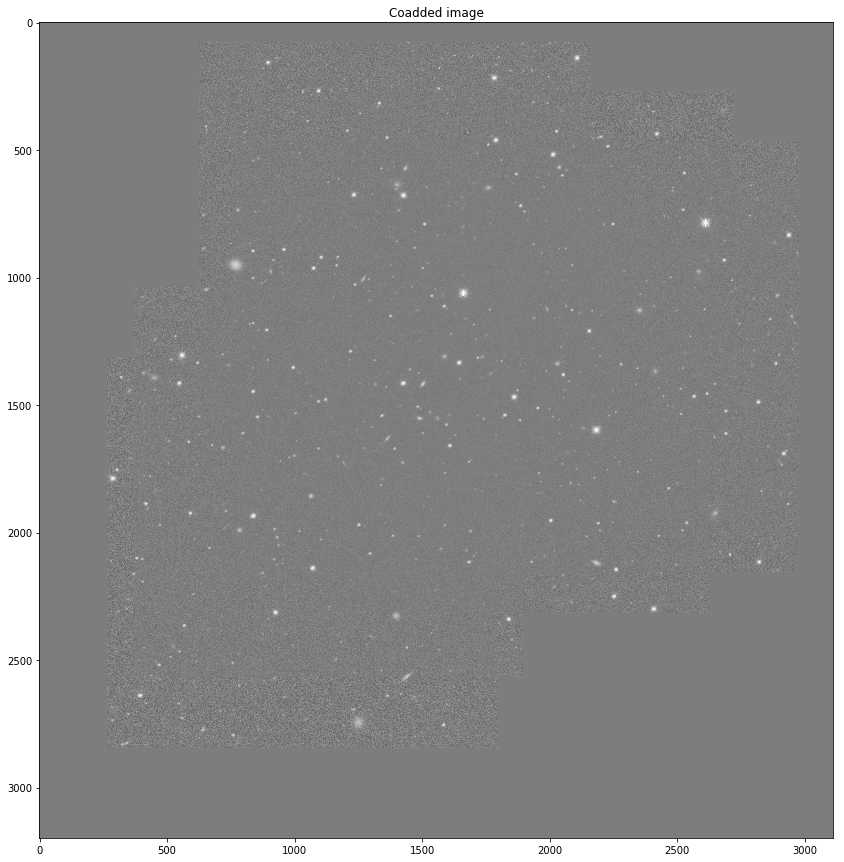

In [7]:
plt.figure(figsize=(15,15))
plt.imshow(coadd_img.data, norm=colors.SymLogNorm(50), cmap=plt.get_cmap('Greys_r'))
plt.title('Coadded image')

### Build a KDTree with the source coordinates

In [8]:
stars_coords = np.stack([g_stars.ra, g_stars.dec]).T
galaxies_coords = np.stack([g_galaxies.ra, g_galaxies.dec]).T
all_coords = np.append(stars_coords, galaxies_coords, axis=0)
all_kdtree = KDTree(all_coords)
g_mags = np.append(g_stars.mag, g_galaxies.mag)

n_stars = len(g_stars)
n_galaxies = len(g_galaxies)

### Load the output catalog

In [9]:
output_catalog = Table.read('/home/aalvarez/Work/Data/sim09/multiframe_output.fits')
# Filter out those that were cut out of the model fitting
output_catalog = output_catalog[((np.isnan(output_catalog['mmf_x']) | np.isnan(output_catalog['mmf_y']))==False)]

Compute magnitudes

In [10]:
# This comes from sim09_*_sky.conf
mag_zeropoint = 26.
exp_time = 300.

In [11]:
output_catalog['g_mag'] = mag_zeropoint - 2.5 * np.log10(output_catalog['mmf_fluxes'] / exp_time)

Note that some entries witll have NaN, since they may not have been on the images used to run SExtractor.

### Compare results

In [12]:
def get_closest(catalog):
    distances = []
    index_c = []
    index_s = []
    for i, e in enumerate(catalog):
        d, s = all_kdtree.query([e['mmf_alpha'], e['mmf_delta']], 1)
        distances.append(d)
        index_c.append(i)
        index_s.append(s)
    return {
        'dist': np.array(distances),
        'catalog': np.array(index_c),
        'source': np.array(index_s),
    }

In [13]:
closest = get_closest(output_catalog)

In [14]:
print("Number of sources found:", len(closest['dist']))

Number of sources found: 853


In [15]:
def plot_stats(ax, data):
    ax.text(
        0.9, 0.9,
        '$\mu$: {:.3e}\n$\sigma$: {:.3e}\n$\%_{{50}}$: {:.3e}'.format(
            np.average(data),
            np.std(data),
            np.median(data),
        ),
        transform=ax.transAxes
    )

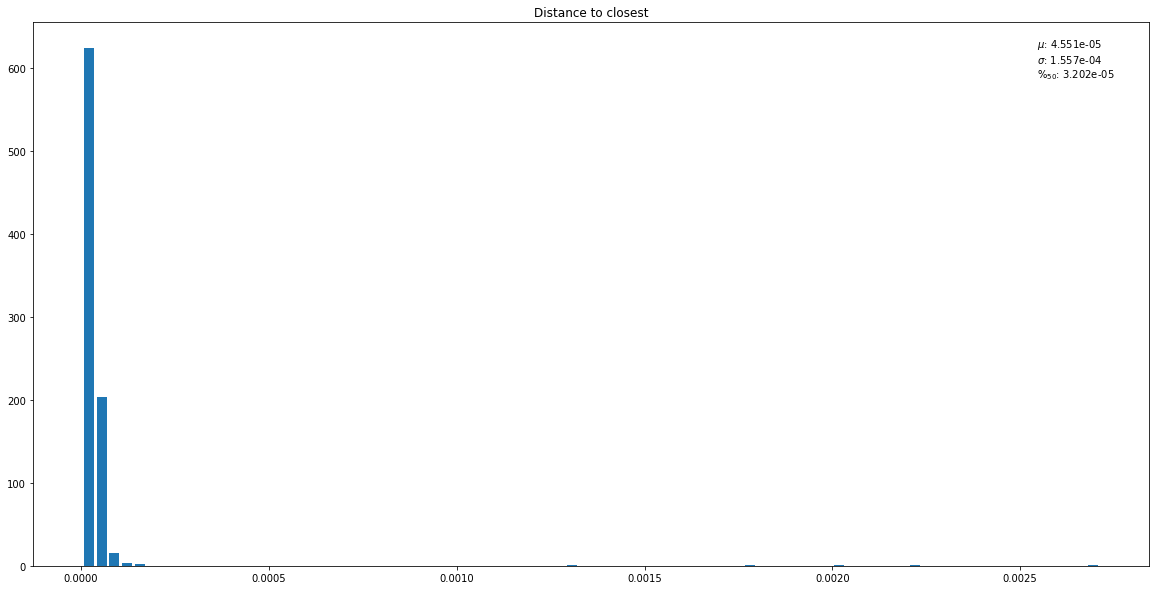

In [16]:
plt.figure(figsize=(20, 10))
ax1 = plt.subplot(1, 1, 1)
ax1.hist(closest['dist'], 80, rwidth=0.8)
plot_stats(ax1, closest['dist'])
_ = ax1.set_title('Distance to closest')

### Magnitudes

In [17]:
g_mag_diff = output_catalog[closest['catalog']]['g_mag'] - g_mags[closest['source']]
# Filter out outliers
outlier_filter = (g_mag_diff >= np.percentile(g_mag_diff, 5)) & (g_mag_diff <= np.percentile(g_mag_diff, 95))

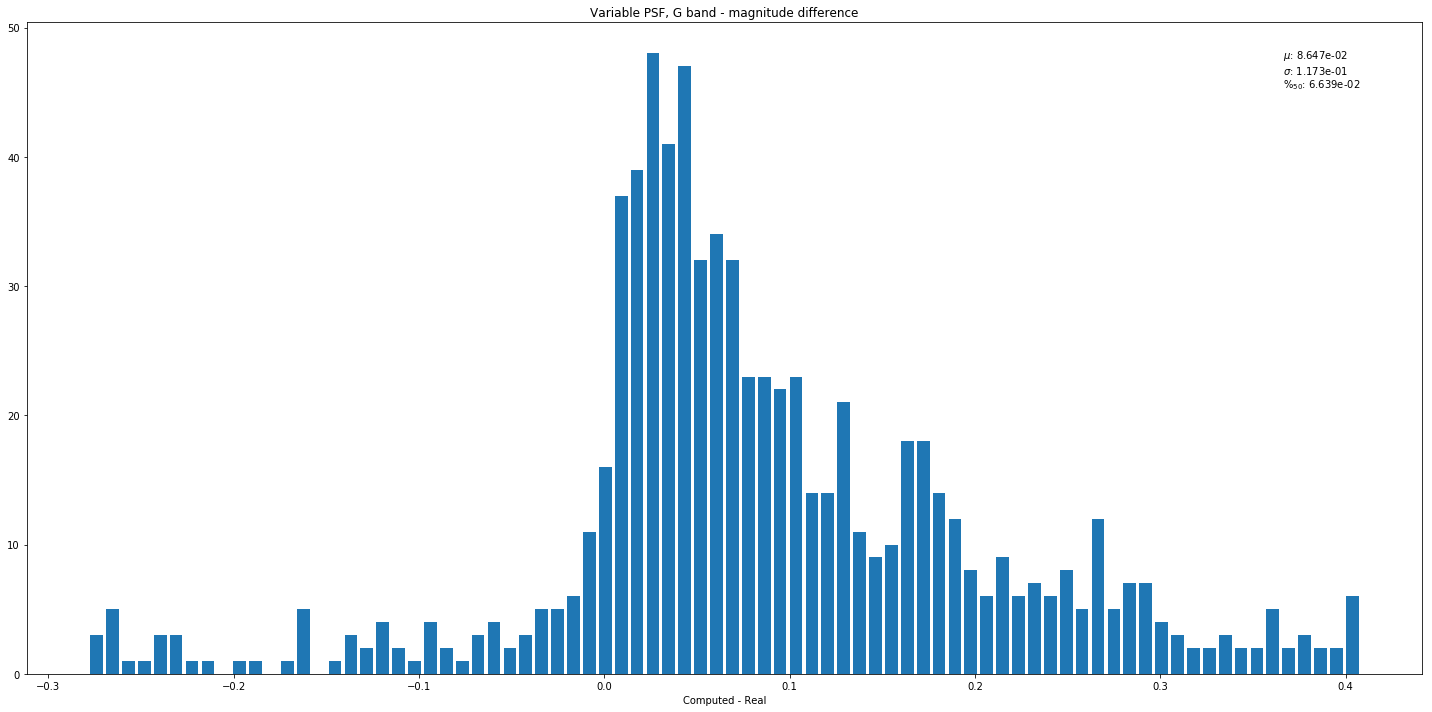

In [18]:
plt.figure(figsize=(20, 10))

ax1 = plt.subplot(1, 1, 1)
ax1.hist(g_mag_diff[outlier_filter], 80, rwidth=0.8)
ax1.set_xlabel('Computed - Real')
plot_stats(ax1, g_mag_diff[outlier_filter])
ax1.set_title('Variable PSF, G band - magnitude difference')

plt.tight_layout()

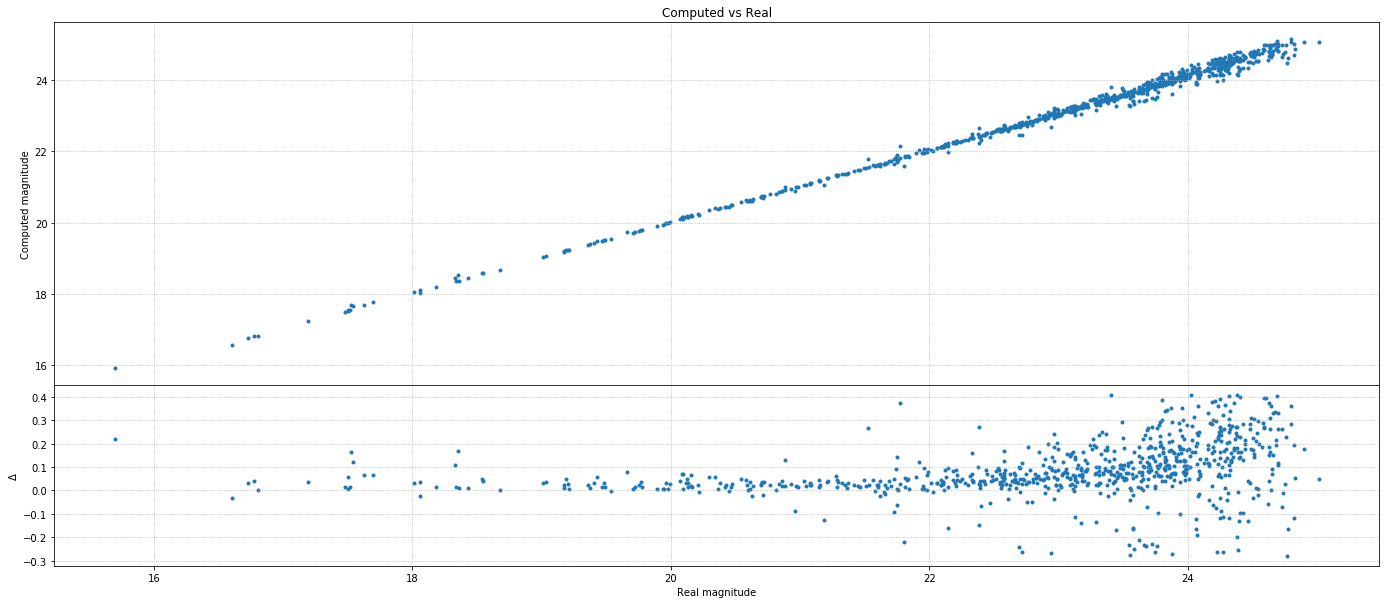

In [19]:
plt.figure(figsize=(20, 10))
plt.subplots_adjust(left=0.07, right=0.99, hspace=0.0, wspace=0.2)

ax1 = plt.subplot2grid((3, 1), (0, 0), 2)
ax1.scatter(
    g_mags[closest['source']][outlier_filter],
    output_catalog[closest['catalog']]['g_mag'][outlier_filter],
    marker='.'
)
ax1.set_ylabel('Computed magnitude')
ax1.set_xlabel('Real magnitude')
ax1.grid(True, linestyle=':')
ax1.set_title('Computed vs Real')

ax2 = plt.subplot2grid((3, 1), (2, 0), 1)
ax2.scatter(
    g_mags[closest['source']][outlier_filter],
    (output_catalog[closest['catalog']]['g_mag'] - g_mags[closest['source']])[outlier_filter],
    marker='.'
)
ax2.set_ylabel('$\Delta$')
ax2.set_xlabel('Real magnitude')
ax2.grid(True, linestyle=':')


_ = 0

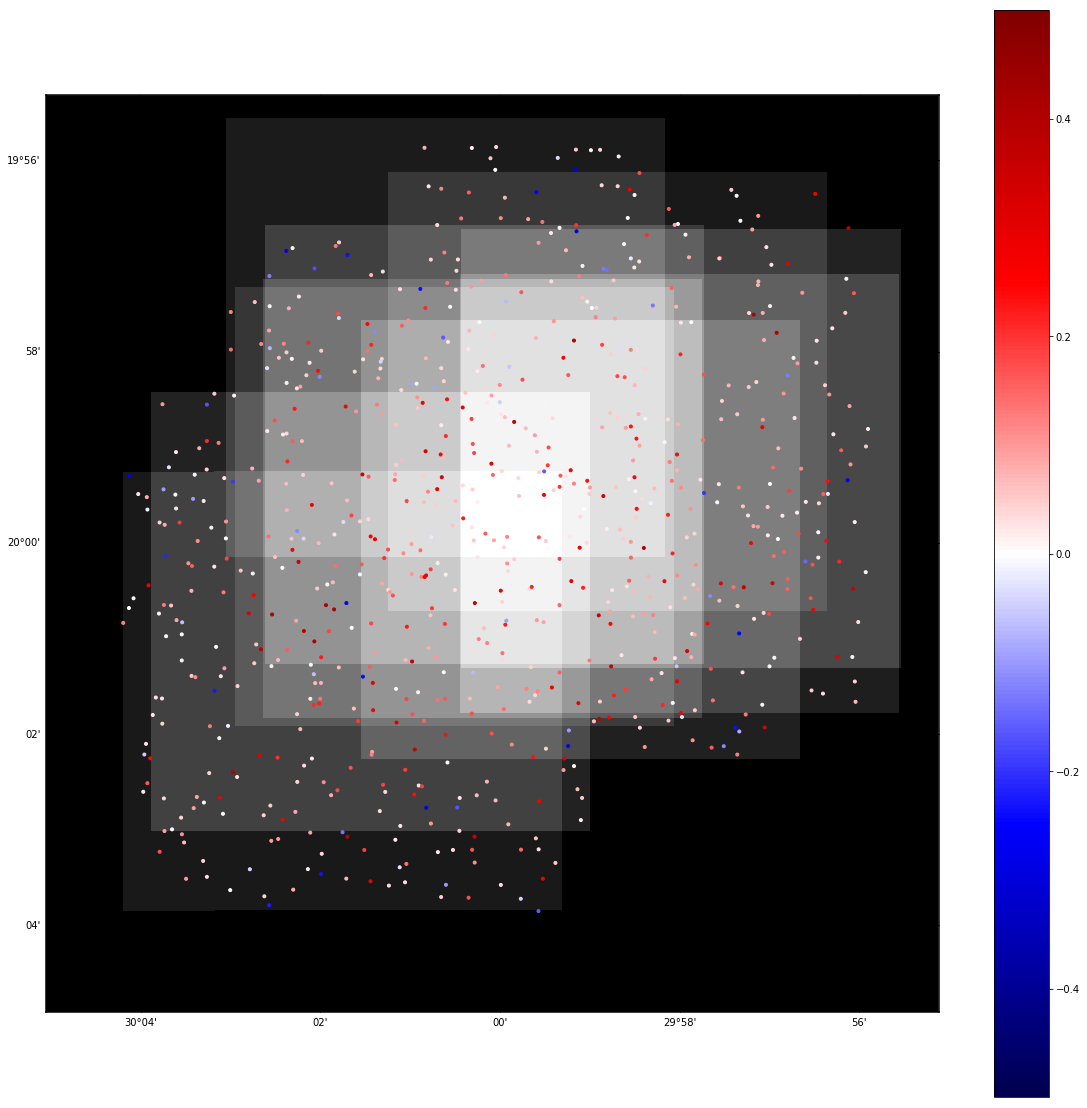

In [20]:
weights = fits.open('/home/aalvarez/Work/Data/sim09/sim09_g.weight.fits')[0]

wcs = WCS(coadd_img.header)
max_abs_diff = np.max(np.abs(g_mag_diff[outlier_filter]))

pixel_coords = wcs.all_world2pix(
    output_catalog[closest['catalog']]['mmf_alpha'][outlier_filter],
    output_catalog[closest['catalog']]['mmf_delta'][outlier_filter],
    0
)

plt.figure(figsize=(20, 20))
ax1 = plt.subplot(1, 1, 1, projection=wcs)
ax1.imshow(weights.data, norm=colors.SymLogNorm(50), cmap=plt.get_cmap('Greys_r'))
sc = ax1.scatter(
    pixel_coords[0],
    pixel_coords[1],
    c=g_mag_diff[outlier_filter],
    marker='.',
    cmap = plt.get_cmap('seismic'),
    norm = colors.Normalize(vmin=-0.5, vmax=0.5)
)
plt.colorbar(sc)